In [1]:
import dicom, cv2, re, sys
import os, fnmatch, shutil, subprocess
import numpy as np
from PIL import Image
import dicom,  cv2, re, sys
import os, fnmatch, shutil, subprocess
from IPython.utils import io
import numpy as np
np.random.seed(1234)
import matplotlib as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os, sys, urllib, gzip
#import cPickle as pickle
import pickle as pickle
sys.setrecursionlimit(10000)
import glob
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image as IPImage

from PIL import Image
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.layers import get_output, InputLayer, DenseLayer, ReshapeLayer
from lasagne.init import GlorotUniform
from lasagne.nonlinearities import rectify, leaky_rectify, tanh, sigmoid, softmax
from lasagne.updates import nesterov_momentum, adam
from lasagne.objectives import categorical_crossentropy, binary_crossentropy
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo
from lasagne.layers import Conv2DLayer as Conv2DLayer
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayer
import theano 
import theano.tensor as T
import lasagne
import time
try:
    from lasagne.layers.dnn import Conv2DDNNLayer as Conv2DLayer
    from lasagne.layers.dnn import MaxPool2DDNNLayer as MaxPool2DLayer
    print("Using cuda_convnet (faster)")
except ImportError:
    from lasagne.layers import Conv2DLayer as Conv2DLayer
    from lasagne.layers import MaxPool2DLayer as MaxPool2DLayer
    print("Using lasagne.layers (slower)")
    
import theano
import theano.tensor as T

from lasagne.layers import Layer
from lasagne import init
from lasagne import nonlinearities
from scipy.misc import imresize, imread
from PIL import ImageOps
import scipy as sp
import scipy.ndimage.morphology
from skimage.morphology import convex_hull_image
from skimage.restoration import denoise_tv_chambolle, denoise_bilateral
import matplotlib.cm as cm
from scipy.optimize import minimize
from math import floor

/home/ora/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
/home/ora/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Using lasagne.layers (slower)


In [2]:
def load_StereoImages(dirpath='./DepthMap_dataset'):
  
    X , X_left,X_right, y =[], [], [], []
    n = 0
    for n in range(1,1000):
        path = ('{}/Depth_map/DepthMap_{}.png').format(dirpath,n)
        with open(path, 'rb') as f:
            depthM = imread(f)
            size_depthM = depthM.shape
            depthM = Image.open(f)
            depthM = depthM.convert('L')
            depthM = np.array(depthM.getdata(),dtype=np.uint8)
        y.append(depthM)
       
    y = np.concatenate(y).reshape(-1, 1, size_depthM[0], size_depthM[1]).astype(np.float32)
    
 
    for n in range(1,1000):
        path = ('{}/StereoImages/Stereoscopic_{}.png').format(dirpath,n)
        with open(path, 'rb') as f:
            StereoIm = imread(f)
            size_StereoIm = StereoIm.shape
            StereoIm = Image.open(f)
            StereoIm = StereoIm.convert('L')
            StereoIm = np.array(StereoIm.getdata(),dtype=np.uint8).reshape(1, size_StereoIm[0], size_StereoIm[1])
          
            Im_left = StereoIm[0,...,0:int(size_StereoIm[1]/2)]
            Im_right = StereoIm[0,...,int(size_StereoIm[1]/2):size_StereoIm[1]]
          
        X.append(StereoIm)
        X_left.append(Im_left)
        X_right.append(Im_right)
        
    X = np.concatenate((X_left,X_right),1).reshape(-1, 2, size_StereoIm[0], int(size_StereoIm[1]/2)).astype(np.float32)
    X_left = np.concatenate(X_left).reshape(-1, 1, size_StereoIm[0], int(size_StereoIm[1]/2)).astype(np.float32)
    X_right = np.concatenate(X_right).reshape(-1, 1, size_StereoIm[0], int(size_StereoIm[1]/2)).astype(np.float32)
  
    ii = np.random.permutation(len(X))

    X_train = X[ii[floor(len(X)*0.1):]]
    X_left_train = X_left[ii[floor(len(X_left)*0.1):]]
    X_right_train = X_right[ii[floor(len(X_right)*0.1):]]
    y_train = y[ii[floor(len(X)*0.1):]]
  
    X_valid = X[ii[:floor(len(X)*0.1)]]
    X_left_valid = X_left[ii[:floor(len(X_left)*0.1)]]
    X_right_valid = X_right[ii[:floor(len(X_right)*0.1)]]
    y_valid = y[ii[:floor(len(X)*0.1)]]
    
  
    offset = np.mean(X_train, 0)
    scale = np.std(X_train, 0).clip(min=1)
    
    y_offset = np.mean(y_train, 0)
    y_scale = y_train.max()
    
    offset_left = np.mean(X_left_train, 0)
    scale_left = np.std(X_left_train, 0).clip(min=1)
    offset_right = np.mean(X_right_train, 0)
    scale_right = np.std(X_right_train, 0).clip(min=1)
    
    X_train = (X_train - offset) / scale
    X_valid = (X_valid - offset) / scale
    
    X_left_train = (X_left_train - offset_left) / scale_left
    X_right_train = (X_right_train - offset_right) / scale_right

    X_left_valid = (X_left_valid - offset_left) / scale_left
    X_right_valid = (X_right_valid - offset_right) / scale_right
    
    y_train = y_train/y_scale
    y_valid = y_valid/y_scale
    
    
    return X_train,X_left_train,X_right_train, y_train, X_valid,X_left_valid,X_right_valid, y_valid
    

In [3]:
X_train,X_left_train,X_right_train, y_train, X_valid,X_left_valid,X_right_valid, y_valid = load_StereoImages()

print("X_train.shape:",X_train.shape)
print("X_left_train.shape:",X_left_train.shape)
print("X_right_train.shape,:",X_right_train.shape)
print("y_train.shape,:",y_train.shape)
print("X_valid.shape,:",X_valid.shape)
print("X_left_valid.shape,:",X_left_valid.shape)
print("X_right_valid.shape,:",X_right_valid.shape)
print("y_valid.shape,:",y_valid.shape)

X_train.shape: (900, 2, 100, 150)
X_left_train.shape: (900, 1, 100, 150)
X_right_train.shape,: (900, 1, 100, 150)
y_train.shape,: (900, 1, 100, 150)
X_valid.shape,: (99, 2, 100, 150)
X_left_valid.shape,: (99, 1, 100, 150)
X_right_valid.shape,: (99, 1, 100, 150)
y_valid.shape,: (99, 1, 100, 150)


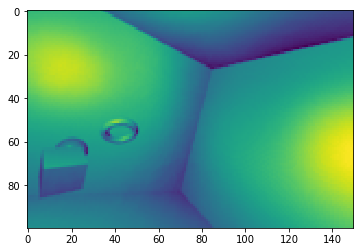

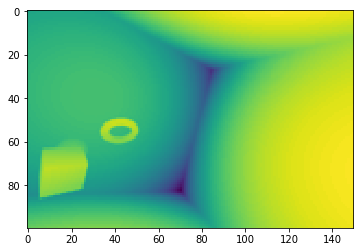

In [6]:
plt.imshow(X_valid[11,0,...])
#plt.imshow(X_valid[11,0,...],cmap = cm.Greys_r)
plt.show()

plt.imshow(y_valid[11,0,...])
#plt.imshow(y_valid[11,0,...],cmap = cm.Greys_r)
plt.show()



In [7]:
from batchNormalization import BatchNormLayer

def batch_norm(layer, **kwargs):
    nonlinearity = getattr(layer, 'nonlinearity', None)
    if nonlinearity is not None:
        layer.nonlinearity = nonlinearities.identity
    if hasattr(layer, 'b') and layer.b is not None:
        del layer.params[layer.b]
        layer.b = None
    layer = BatchNormLayer(layer, **kwargs)
    if nonlinearity is not None:
        from lasagne.layers import NonlinearityLayer
        layer = NonlinearityLayer(layer, nonlinearity)
    return layer

In [8]:
def build_stereo_cnn(input_var=None):
    
    conv_num_filters1 = 16
    conv_num_filters2 = 32
    conv_num_filters3 = 64
    conv_num_filters4 = 128
    filter_size1 = 7
    filter_size2 = 5
    filter_size3 = 3
    filter_size4 = 3
    pool_size = 2
    scale_factor = 2
    pad_in = 'valid'
    pad_out = 'full'

                                                                                                                                                                                
    network = InputLayer(shape=(None,2, X_train.shape[2], X_train.shape[3]),input_var=input_var,name="input_layer")                                                                                                                             
        
    network = batch_norm(Conv2DLayer(
            network, num_filters=conv_num_filters1, filter_size=(filter_size1, filter_size1),pad=pad_in,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="conv1"))
    
    network = MaxPool2DLayer(network, pool_size=(pool_size, pool_size),name="pool1")
    
    network = batch_norm(Conv2DLayer(
            network, num_filters=conv_num_filters2, filter_size=(filter_size2, filter_size2),pad=pad_in,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="conv2"))
    
    network = MaxPool2DLayer(network, pool_size=(pool_size, pool_size),name="pool2")
                                                                                                                                     
    network = batch_norm(Conv2DLayer(
            network, num_filters=conv_num_filters3, filter_size=(filter_size3, filter_size3),pad=pad_in,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="conv3"))
    
    network = MaxPool2DLayer(network, pool_size=(pool_size, pool_size),name="pool3")
                                                                                                                                     
    network = batch_norm(Conv2DLayer(
            network, num_filters=conv_num_filters4, filter_size=(filter_size4, filter_size4),pad=pad_in,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="conv4"))
    
    network = batch_norm(Conv2DLayer(
            network, num_filters=32, filter_size=(filter_size4, filter_size4),pad=pad_out,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="deconv1"))
    
    network = Upscale2DLayer(network, scale_factor=(pool_size, pool_size),name="upscale1")
    
    network = batch_norm(Conv2DLayer(
            network, num_filters=16, filter_size=(filter_size3, filter_size3),pad=pad_out,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="deconv2"))
    
    network = Upscale2DLayer(network, scale_factor=(pool_size, pool_size),name="upscale2")
    
    network = batch_norm(Conv2DLayer(
            network, num_filters=8, filter_size=(filter_size2, filter_size2),pad=pad_out,
            nonlinearity=lasagne.nonlinearities.rectify,
            W=lasagne.init.GlorotUniform(),name="deconv3"))
    
    network = Upscale2DLayer(network, scale_factor=(pool_size, pool_size),name="upscale3")
    
    network = batch_norm(Conv2DLayer(
            network, num_filters=1, filter_size=(filter_size1, filter_size1),pad=pad_out,
            nonlinearity=lasagne.nonlinearities.sigmoid,
            W=lasagne.init.GlorotUniform(),name="deconv4"))
                                 
    return network


In [9]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def iterator(X, batchsize):
    indices = np.arange(len(X))
    for i in range(0, len(X) - batchsize + 1, batchsize):
        sli = indices[i:i+batchsize]
        yield X[sli]

In [10]:
def save_params(model, fn):
    with open(fn, 'w') as wr:
        pickle.dump(lasagne.layers.get_all_param_values(model), wr)
        
def dice_loss(predictions, targets):
    dice_index = 2*T.sum(predictions*targets)/((T.sum(predictions)+T.sum(targets)))
    return -dice_index


In [20]:
from tqdm import tqdm

def main(num_epochs=200):
                                                                                                                                                                                     
    #print("Loading data...")
    X_train,X_left_train,X_right_train, y_train, X_val,X_left_val,X_right_val, y_val = load_StereoImages()
    
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    
    Y_train =[]
    for i in range(y_train.shape[0]):
        #print(y_train[i].shape) # 1 100 150  
        Y =y_train[i][...,3:y_train.shape[2]-3,0:y_train.shape[3]]# 1 94 150
        Y_train.append(Y)
        #print(Y.shape)
    Y_train = np.concatenate(Y_train).reshape(-1, 1, Y.shape[1], Y.shape[2]).astype(np.float32) 
    
    Y_val =[]
    for i in range(y_val.shape[0]):
       
        Y =y_val[i][...,3:y_val.shape[2]-3,0:y_val.shape[3]]# 1 94 150
        Y_val.append(Y)
        #print(Y.shape)
    Y_val = np.concatenate(Y_val).reshape(-1, 1, Y.shape[1], Y.shape[2]).astype(np.float32) 
    
        
#    print("Y_train",Y_train.shape)  # (900, 1, 94, 150)

    
#    print ('X_train type and shape:', X_train.dtype, X_train.shape)
    #print ('X_train.min():', X_train.min())
    #print ('X_train.max():', X_train.max())

#    print ('X_val type and shape:', X_val.dtype, X_val.shape)
    #print ('X_val.min():', X_val.min())
    #print ('X_val.max():', X_val.max())
    
#    print ('y_train type and shape:', y_train.dtype, y_train.shape)
    #print ('y_train.min():', y_train.min())
    #print ('y_train.max():', y_train.max())

#    print ('y_val type and shape:', y_val.dtype, y_val.shape)
    #print ('y_val.min():', y_val.min())
    #print ('y_val.max():', y_val.max())
    
                                                                                                                                                       
    input_var = T.tensor4('inputs',dtype=theano.config.floatX)
    target_var = T.tensor4('targets',dtype=theano.config.floatX)

  
    network = build_stereo_cnn(input_var)
    laylist = lasagne.layers.get_all_layers(network)
    
    #for l in laylist:
        #print (l.name, lasagne.layers.get_output_shape(l))
        
   
    prediction = lasagne.layers.get_output(network)
    dloss = lasagne.objectives.squared_error(prediction, target_var)
    dloss = dloss.mean()
    
  
    params = lasagne.layers.get_all_params(network, trainable=True)
    updates2 = lasagne.updates.adam(
            dloss, params, learning_rate=0.01)

   
    test_prediction = lasagne.layers.get_output(network, deterministic=True)
    test_loss2 = lasagne.objectives.squared_error(test_prediction,target_var)
    test_loss2 = test_loss2.mean()

  
    train_fn2 = theano.function([input_var, target_var], dloss, updates=updates2)

   
    val_fn2 = theano.function([input_var, target_var], [test_loss2])

   
    #print("Starting training...")
                                                                                                                                                                         
    for epoch in tqdm(range(num_epochs)):
      
        train_err = 0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(X_train, Y_train, 16, shuffle=True):
            inputs, targets = batch
            train_err += train_fn2(inputs, targets)
            train_batches += 1
            
     
        val_err = 0
        val_batches = 0
        for batch in iterate_minibatches(X_val, Y_val, 16, shuffle=False):
            inputs, targets = batch
            err = val_fn2(inputs, targets)
            val_err += err[0]
            val_batches += 1

                                                                                                                                                              
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss:\t\t{:.6f}".format(train_err / train_batches))
        print("  validation loss:\t\t{:.6f}".format(val_err / val_batches))
        print("  ratio:\t\t{:.6f}".format((train_err / train_batches)/(val_err / val_batches)))

        np.savez('model_stereo_11.8.npz', *lasagne.layers.get_all_param_values(network)) 

    return X_train,X_left_train,X_right_train, y_train, X_val,X_left_val,X_right_val, y_val
    

In [ ]:
X_train,X_left_train,X_right_train, y_train, X_val,X_left_val,X_right_val, y_val = main(num_epochs=5000)


  0%|          | 1/5000 [01:24<117:55:54, 84.93s/it]

Epoch 1 of 5000 took 84.887s
  training loss:		0.020279
  validation loss:		0.049231
  ratio:		0.411925


  0%|          | 2/5000 [02:53<119:17:32, 85.92s/it]

Epoch 2 of 5000 took 88.208s
  training loss:		0.008905
  validation loss:		0.005718
  ratio:		1.557323


In [12]:
input_var = T.tensor4('inputs',dtype=theano.config.floatX)
network = build_stereo_cnn(input_var)
with np.load('model_stereo_11.8.npz') as f:                                                                                                                                                                       
    param_values = [f['arr_%d' % i] for i in range(len(f.files))]                                                                                                                                     
    lasagne.layers.set_all_param_values(network, param_values)  
test_prediction = lasagne.layers.get_output(network, deterministic=True)
pred_fn = theano.function([input_var], [test_prediction])

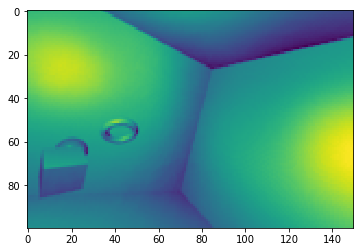

(100, 150)


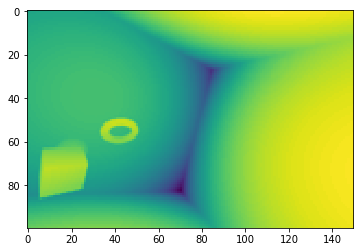

(1, 1, 94, 150)


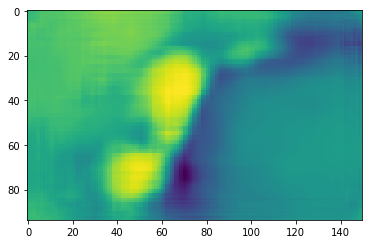

In [15]:
# 原图
Im_num = 11
a = X_valid[Im_num,0,...]
#plt.imshow(a,cmap = cm.Greys_r)
plt.imshow(a)
plt.show()
# X_valid[Im_num:Im_num+1,1,...] = X_valid[Im_num:Im_num+1,0,...]

# ground truth 实际值
print (y_valid[Im_num,0,...].shape)
#plt.imshow(y_valid[Im_num,0,...],cmap = cm.Greys_r)
plt.imshow(y_valid[Im_num,0,...])
plt.show()

# 预测
b = pred_fn(X_valid[Im_num:Im_num+1,...])
print (b[0].shape)
b = b[0]
#plt.imshow(b[0,0,...],cmap = cm.Greys_r)
plt.imshow(b[0,0,...])
plt.show()
